In [81]:
import numpy as np
import pandas as pd

In [82]:
data = pd.read_csv(r"")

In [83]:
data.head()

,Date,Adj Close
0,30/10/2013,105.445374
1,31/10/2013,105.823196
2,01/11/2013,105.407578
3,04/11/2013,105.256462
4,05/11/2013,105.407578


In [84]:
data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y")
data = data.sort_values(by="Date")
data["Log Returns"] = np.log(data["Adj Close"]) - np.log(data["Adj Close"].shift(1))
data = data.dropna()

data.head()

,Date,Adj Close,Log Returns
1,2013-10-31,105.823196,0.003577
2,2013-11-01,105.407578,-0.003935
3,2013-11-04,105.256462,-0.001435
4,2013-11-05,105.407578,0.001435
5,2013-11-06,104.463081,-0.009001


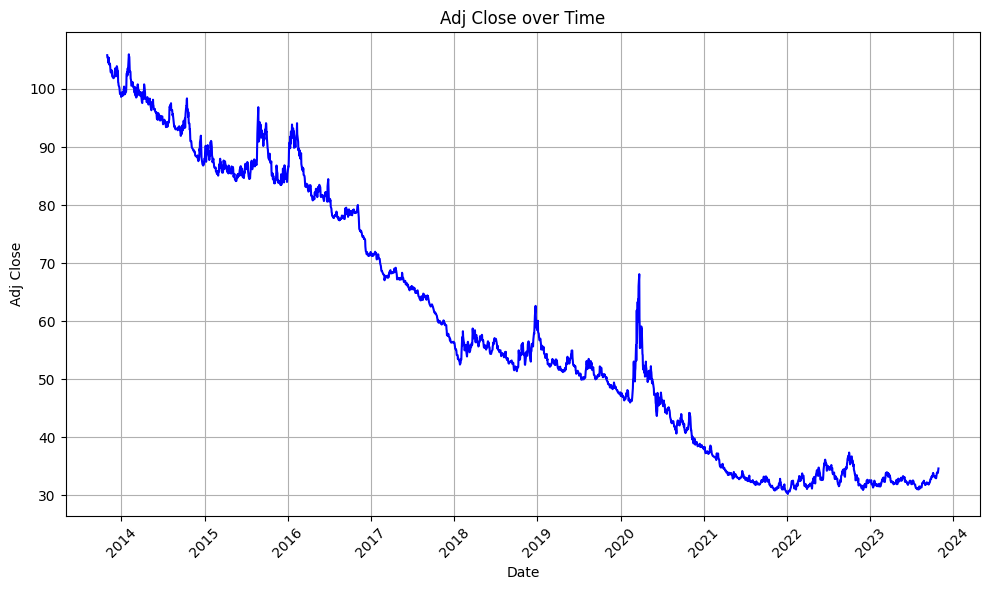

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Adj Close'], color='blue')
plt.title('Adj Close over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()


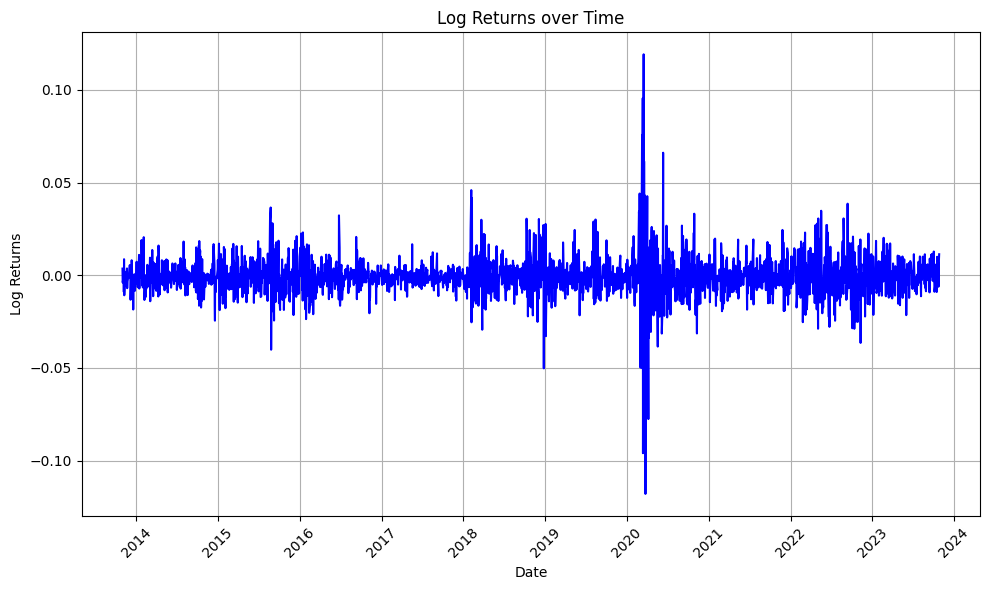

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Log Returns'], color='blue')
plt.title('Log Returns over Time')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
from scipy.stats import skew, kurtosis

mean_log_returns = np.mean(data['Log Returns'])
std_dev_log_returns = np.std(data['Log Returns'])
skewness_log_returns = skew(data['Log Returns'])
kurtosis_log_returns = kurtosis(data['Log Returns'])

print("Mean of log returns:", mean_log_returns)
print("Standard deviation of log returns:", std_dev_log_returns)
print("Skewness of log returns:", skewness_log_returns)
print("Kurtosis of log returns:", kurtosis_log_returns)

Mean of log returns: -0.00044261788548880367
Standard deviation of log returns: 0.010907868423932713
Skewness of log returns: 0.23694823882159455
Kurtosis of log returns: 20.24505783022885


In [88]:
!pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


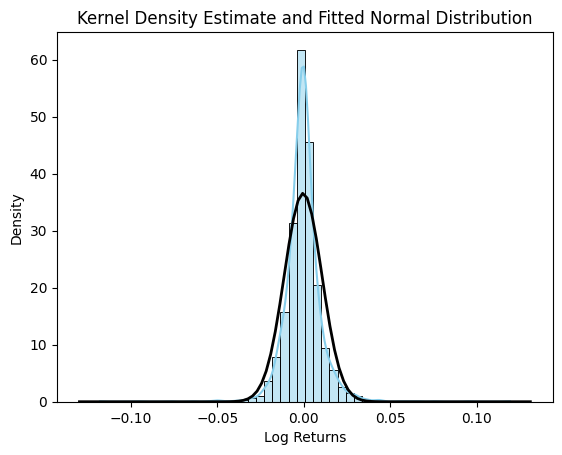

In [89]:
import seaborn as sns
from scipy.stats import norm

mu, std = norm.fit(data['Log Returns'])

sns.histplot(data['Log Returns'], kde=True, stat='density', color='skyblue', bins=50)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Kernel Density Estimate and Fitted Normal Distribution')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.show()


<Figure size 1000x600 with 0 Axes>

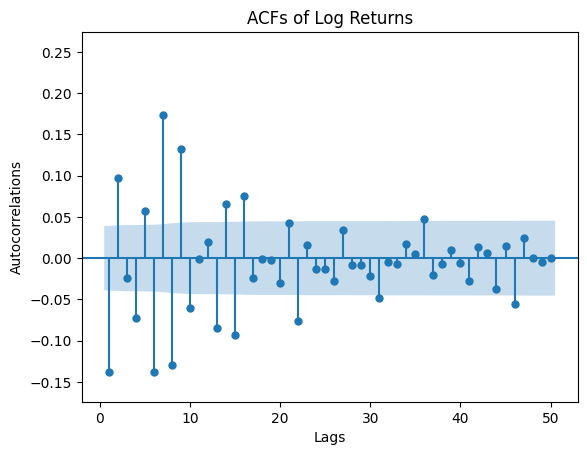

In [90]:
import statsmodels.api as sm

acf_log_returns = sm.tsa.acf(data['Log Returns'], nlags=51)[1:]

plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(data['Log Returns'], lags=50, zero=False)
plt.title('ACFs of Log Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelations')

max_abs_correlation = np.max(np.abs(acf_log_returns))
plt.ylim(-max_abs_correlation, max_abs_correlation + 0.1)

plt.show()


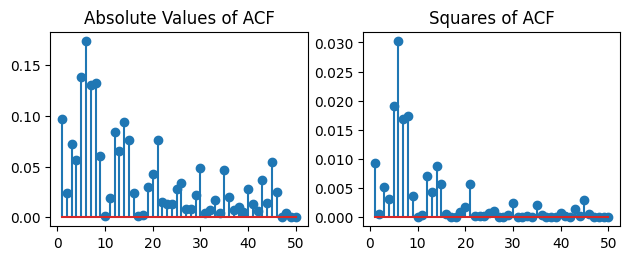

In [91]:
abs_acf_log_returns = np.abs(acf_log_returns[1:]) 
squared_acf_log_returns = acf_log_returns[1:] ** 2

n_lags = len(abs_acf_log_returns)
lags = range(1, n_lags + 1)

plt.subplot(2, 2, 1)
plt.stem(lags, abs_acf_log_returns)
plt.title('Absolute Values of ACF')

plt.subplot(2, 2, 2)
plt.stem(lags, squared_acf_log_returns)
plt.title('Squares of ACF')

plt.tight_layout()
plt.show()


In [92]:
import arch
from arch import arch_model

garch_model = arch_model(data['Log Returns'], mean='Constant', dist='Normal', vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')

print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2433.36
Distribution:                  Normal   AIC:                          -4858.73
Method:            Maximum Likelihood   BIC:                          -4835.41
                                        No. Observations:                 2515
Date:                Sat, Mar 23 2024   Df Residuals:                     2514
Time:                        15:09:15   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0865  7.013e-03     12.330  6.206e-35 [7.273e-0

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


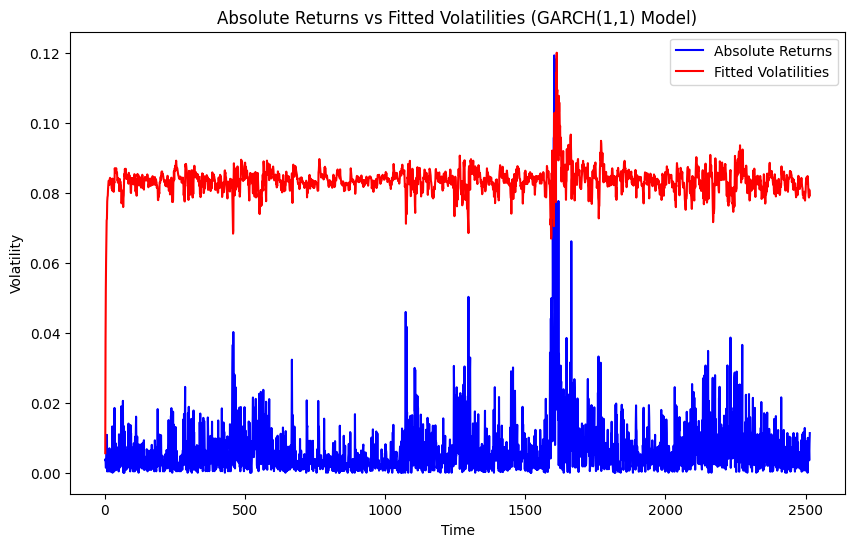

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(data['Log Returns'].abs(), label='Absolute Returns', color='blue')

plt.plot(garch_result.conditional_volatility, label='Fitted Volatilities', color='red')

plt.title('Absolute Returns vs Fitted Volatilities (GARCH(1,1) Model)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


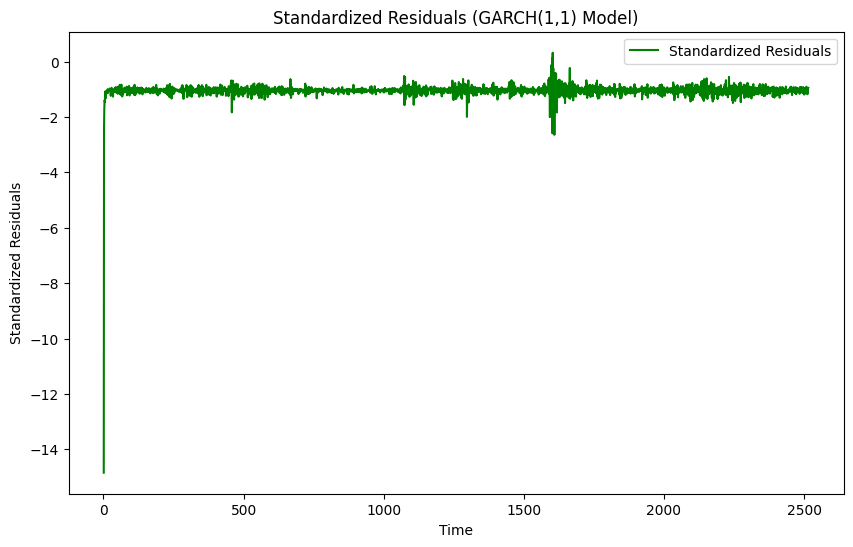

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(garch_result.resid / garch_result.conditional_volatility, label='Standardized Residuals', color='green')
plt.title('Standardized Residuals (GARCH(1,1) Model)')
plt.xlabel('Time')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.show()

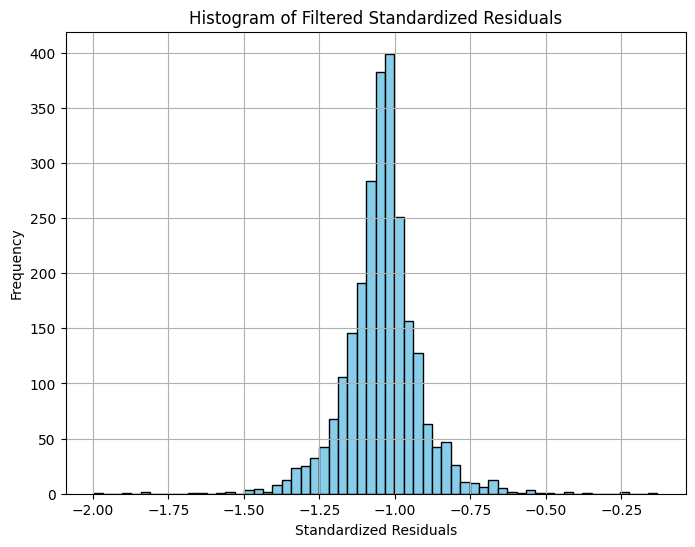

In [95]:
filtered_residuals = garch_result.resid / garch_result.conditional_volatility
filtered_residuals = filtered_residuals[(filtered_residuals >= -2) & (filtered_residuals <= 0)]

plt.figure(figsize=(8, 6))
plt.hist(filtered_residuals, bins=60, color='skyblue', edgecolor='black')
plt.title('Histogram of Filtered Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Summary Statistics of Standardized Residuals:
Mean: -1.0494645236485516
Standard Deviation: 0.31070982229278626
Skewness: -34.881725798007146
Kurtosis: 1543.140406721966


<Figure size 1000x600 with 0 Axes>

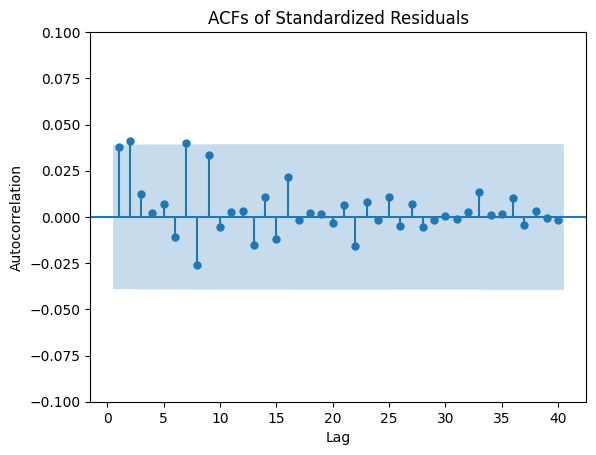

In [96]:
standardized_residuals = garch_result.resid / garch_result.conditional_volatility

residual_mean = np.mean(standardized_residuals)
residual_std_dev = np.std(standardized_residuals)
residual_skewness = skew(standardized_residuals)
residual_kurtosis = kurtosis(standardized_residuals)

print("Summary Statistics of Standardized Residuals:")
print("Mean:", residual_mean)
print("Standard Deviation:", residual_std_dev)
print("Skewness:", residual_skewness)
print("Kurtosis:", residual_kurtosis)

plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(standardized_residuals, lags=40, zero=False)
plt.title('ACFs of Standardized Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-0.1, 0.1) 
plt.show()


In [97]:
standardized_residuals = garch_result.resid / garch_result.conditional_volatility

filtered_residuals = standardized_residuals[(standardized_residuals >= -2) & (standardized_residuals <= 0)]

residual_mean = np.mean(filtered_residuals)
residual_std_dev = np.std(filtered_residuals)
residual_skewness = skew(filtered_residuals)
residual_kurtosis = kurtosis(filtered_residuals)

print("Summary Statistics of Filtered Standardized Residuals (-2 to 0):")
print("Mean:", residual_mean)
print("Standard Deviation:", residual_std_dev)
print("Skewness:", residual_skewness)
print("Kurtosis:", residual_kurtosis)


Summary Statistics of Filtered Standardized Residuals (-2 to 0):
Mean: -1.0427969728613935
Standard Deviation: 0.12857981731828746
Skewness: -0.0377048462508458
Kurtosis: 7.206096793743363


In [99]:
from statsmodels.stats.diagnostic import acorr_ljungbox

a = acorr_ljungbox(standardized_residuals, lags=10)

print(a)


      lb_stat  lb_pvalue
1    3.571752   0.058770
2    7.847883   0.019763
3    8.233376   0.041427
4    8.244840   0.083010
5    8.361605   0.137401
6    8.669948   0.193008
7   12.704015   0.079657
8   14.407954   0.071733
9   17.280354   0.044502
10  17.359034   0.066787
